<a href="https://colab.research.google.com/github/pyreyes/solar_panel_segmentation/blob/main/Inference_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

os.chdir('gdrive/My Drive/CS7150_DeepLearning/Project/logs')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!wget https://drive.google.com/file/d/1yeeppD-PbpDU1eD7F8rLqivNeRyGY6nq/export=download

--2022-05-08 16:26:26--  https://drive.google.com/file/d/1yeeppD-PbpDU1eD7F8rLqivNeRyGY6nq/export=download
Resolving drive.google.com (drive.google.com)... 74.125.199.102, 74.125.199.100, 74.125.199.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.199.102|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-05-08 16:26:26 ERROR 404: Not Found.



In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.3 MB 11.5 MB/s 
     |████████████████████████████████| 190 kB 7.9 MB/s 


In [ ]:
!pip install mmsegmentation

     |████████████████████████████████| 803 kB 8.2 MB/s 
     |████████████████████████████████| 572 kB 56.7 MB/s 


In [ ]:
from mmcv import Config

def get_deeplab_config():
  cfg = Config()
  cfg.model = dict(type = 'EncoderDecoder')
  cfg.crop_size = (512, 512)
  cfg.norm_cfg = dict(requires_grad=True, type='BN')
  cfg.model.backbone = dict(
      type = 'ResNetV1c',
      contract_dilation= True,
      depth = 101,
      multi_grid= (1, 2, 4),
      norm_cfg = cfg.norm_cfg,
      norm_eval= False,
      num_stages = 4,
      out_indices = (0, 1, 2, 3),
      strides = (1, 2, 2, 1),
      style = 'pytorch',
  )
  cfg.model.decode_head = dict(
      type='DepthwiseSeparableASPPHead',
      c1_channels = 48,
      c1_in_channels = 256,
      channels = 512,
      dilations = (1, 6, 12, 18),
      dropout_ratio = 0.1,
      in_channels = 2048,
      in_index = 3,
      norm_cfg = cfg.norm_cfg,
      num_classes = 2,
      loss_decode = dict(loss_weigh=1.0, type='DiceLoss'),
  )

  cfg.model.test_cfg = Config(dict(mode= 'whole'))
  cfg.img_norm_cfg = dict(mean = [123.675, 116.28, 103.53],
                              std = [58.395, 57.12, 57.375],
                              to_rgb = True)   
  cfg.test_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(
          type='MultiScaleFlipAug',
          img_scale=(1024,1024),
          flip=False,
          transforms=[
              dict(type='Resize', keep_ratio=True),
              dict(type='ResizeToMultiple', size_divisor=32),
              dict(type='Normalize', **cfg.img_norm_cfg),
              dict(type='ImageToTensor', keys=['img']),
              dict(type='Collect', keys=['img']),
          ])
  ]
  cfg.data = {}
  cfg.data.test = Config(dict(
                      pipeline = cfg.test_pipeline))
  return cfg


In [ ]:
def get_segformer_config():
  cfg = Config()
  cfg.model = dict(type = 'EncoderDecoder')
  cfg.crop_size = (512, 512)
  cfg.model.backbone = dict(
      type = 'MixVisionTransformer',
      in_channels=3,
      embed_dims = 64,
      num_stages = 4,
      # The layer number of each transformer encode layer
      num_layers = [3, 4, 18, 3],
      # num_layers = [3, 3, 3, 3],
      # the attention heads of each transformer encode layer
      num_heads = [1, 2, 5, 8],
      # the patch_size of each overlapped patch embedding
      patch_sizes = [7, 3, 3, 3],
      # the stride of each overlapped patch embedding
      strides = [4, 2, 2, 2],
      # the spatial reduction rate of each transformer encode layer
      sr_ratios = [8, 4, 2, 1],
      # Output from which stages
      out_indices = (0, 1, 2, 3),
      # ratio of mlp hidden dim to embedding dim
      mlp_ratio = 4,
      # Enable bias for qkv if True
      qkv_bias = True,
      drop_rate = 0.0,
      # The drop out rate for attention layer
      attn_drop_rate = 0.0,
      # stochastic depth rate
      drop_path_rate = 0.1,
      # Config dict for normalization layer
      norm_cfg = dict(type='LN'),
      # The activation config for FFNs
      act_cfg = dict(type='GELU'),
  )
  cfg.model.decode_head = dict(
      type='SegformerHead',
      in_channels = [64, 128, 320, 512],
      channels = 256,
      num_classes = 2,
      dropout_ratio = 0.1,
      # Config of norm layers
      norm_cfg = {'requires_grad': True, 'type': 'BN'},
      # Input feature index
      in_index = [0, 1, 2, 3],
      loss_decode = dict(loss_weigh=1.0, type='DiceLoss'),
  )

  cfg.model.test_cfg = Config(dict(mode= 'whole'))
  cfg.img_norm_cfg = dict(mean = [123.675, 116.28, 103.53],
                              std = [58.395, 57.12, 57.375],
                              to_rgb = True)
  cfg.test_pipeline = [
      dict(type='LoadImageFromFile'),
      dict(
          type='MultiScaleFlipAug',
          img_scale=(1024,1024),
          flip=False,
          transforms=[
              dict(type='Resize', keep_ratio=True),
              dict(type='ResizeToMultiple', size_divisor=32),
              dict(type='Normalize', **cfg.img_norm_cfg),
              dict(type='ImageToTensor', keys=['img']),
              dict(type='Collect', keys=['img']),
          ])
  ] 
  cfg.data = {}
  cfg.data.test = Config(dict(pipeline = cfg.test_pipeline))
  return cfg

In [ ]:
from mmseg.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
from mmseg.models import build_segmentor
import torch
def inference(cfg, checkpoint_file, filename):
  model = build_segmentor(cfg.model)
  # load model weights from checkpoint
  checkpoint = mmcv.runner.checkpoint.load_checkpoint(model,checkpoint_file)
  model.CLASSES = checkpoint['meta']['CLASSES']
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  img = mmcv.imread(filename)
  results = dict(img=img, img_info=dict(filename=filename))

  test_pipeline = cfg.data.test.pipeline
  test_pipeline = Compose(test_pipeline)
  data = test_pipeline(results)
  data = collate([data], samples_per_gpu=1)
  data = scatter(data, [device])[0]
  with torch.no_grad():
      result = model(return_loss=False, rescale=True, **data)
  seg = result[0]
  import matplotlib.pyplot as plt
  palette = [[0,0,0],[220,0,220]]
  predicted_mask = model.show_result(img,result,palette=palette,show=False,opacity=0.4)
  palette = np.array(palette)
  # color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
  # for label, color in enumerate(palette):
  #     color_seg[seg == label, :] = color
  # # convert to BGR
  # color_seg = color_seg[..., ::-1]

  plt.figure(figsize=(15, 10))
  ax = plt.gca()
  ax.axes.xaxis.set_visible(False)
  ax.axes.yaxis.set_visible(False)
  
  plt.imshow(mmcv.bgr2rgb(predicted_mask))

load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/deeplabv3plus/pretrain/latest.pth


/usr/local/lib/python3.7/dist-packages/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


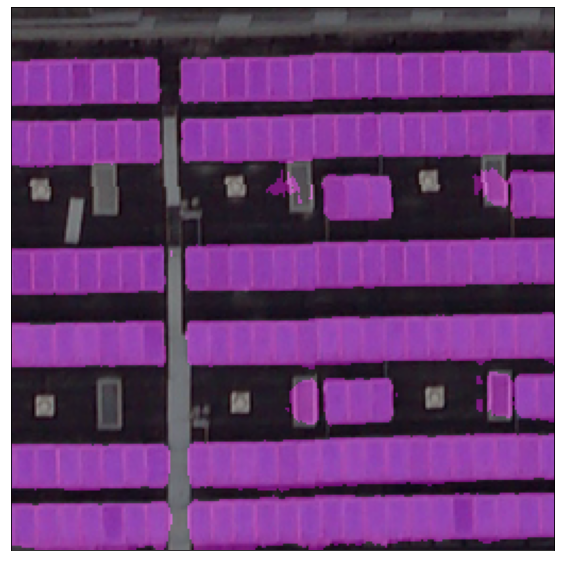

In [ ]:
import mmcv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
filename = '/content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/Demo/images/PV01_325365_1205361.bmp'
deeplab_checkpoint = '/content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/deeplabv3plus/pretrain/latest.pth'

inference(get_deeplab_config(), deeplab_checkpoint, filename)

load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/segFormer/SegFormer/latest.pth


/usr/local/lib/python3.7/dist-packages/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


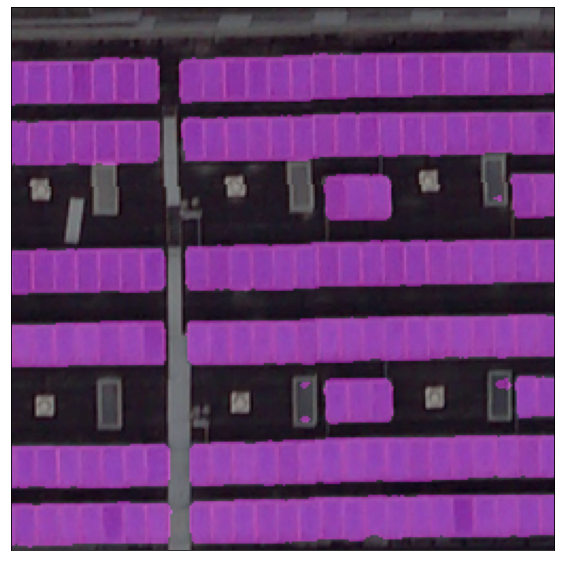

In [ ]:
segformer_checkpoint = '/content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/segFormer/SegFormer/latest.pth'
inference(get_segformer_config(), segformer_checkpoint, filename)

load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/deeplabv3plus/pretrain/latest.pth


/usr/local/lib/python3.7/dist-packages/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/segFormer/SegFormer/latest.pth


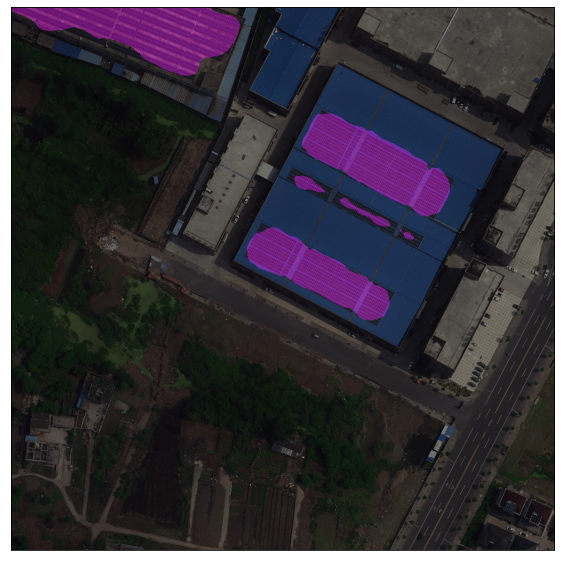

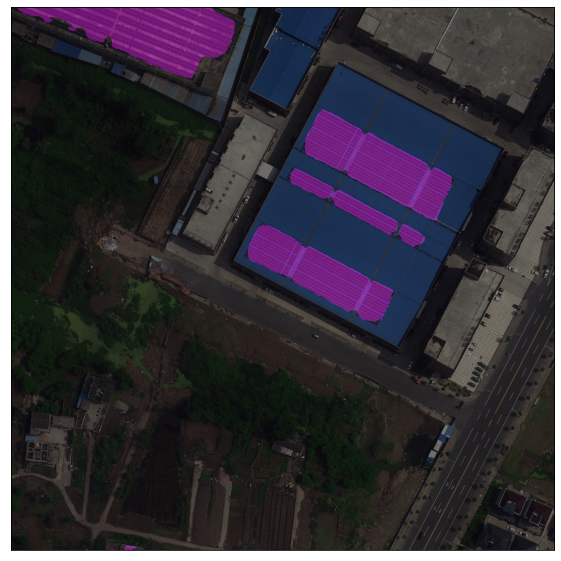

In [ ]:
filename = '/content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/Demo/images/PV03_322580_1198220.bmp'
inference(get_deeplab_config(), deeplab_checkpoint, filename)
inference(get_segformer_config(), segformer_checkpoint, filename)

load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/deeplabv3plus/pretrain/latest.pth


/usr/local/lib/python3.7/dist-packages/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


load checkpoint from local path: /content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/segFormer/SegFormer/latest.pth


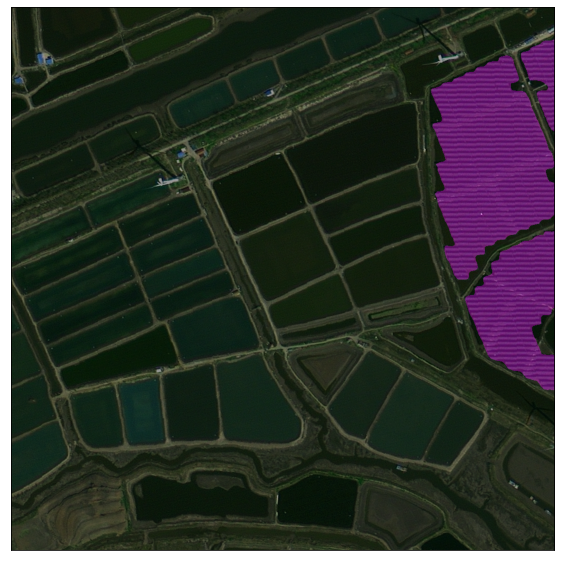

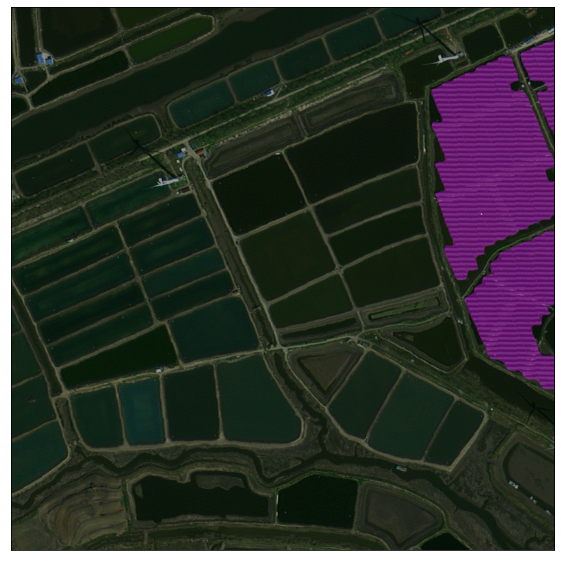

In [ ]:
filename = '/content/gdrive/MyDrive/CS7150_DeepLearning/Project/logs/Demo/images/PV08_322227_1213828.bmp'
inference(get_deeplab_config(), deeplab_checkpoint, filename)
inference(get_segformer_config(), segformer_checkpoint, filename)